# Linear Classification

 Implement Linear Classification using pytorch. This consists of having fully connected layers connected one after the other and ReLu activation functions between them.
 
 Build a neural network with a minimun of 2 layers in order to do classification.

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data as utils
import time
import pdb
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

torch.manual_seed(1)    # reproducible

In [85]:
def get_train_valid_loader(data_dir='../data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=False,
                           num_workers=0,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


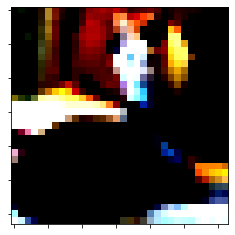

In [86]:
import matplotlib.pyplot as plt
f = plt.figure(figsize = (4, 4))

images, labels = iter(trainloader).next()
plt.imshow(np.moveaxis(images[0].numpy(), 0, -1))

In [209]:
class Net(torch.nn.Module):
    def __init__(self, kernel_size = 5):
        super(Net, self).__init__()
        self.kernel_size = kernel_size
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        self.conv1 = nn.Conv2d(3, 6, kernel_size)
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################


    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        ################################################################################
        
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 16 * 6 * 6)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        return x


In [210]:
################################################################################
# TODO:                                                                        #
# Define the parameters of the network the way you want it to be.              #
# Choose an Optimizer that will be used to minimize the loss function.         #
################################################################################
net = Net(kernel_size= 3)     # define the network
print(net)  # net architecture

# Loss and Optimizer (Try different learning rates)
# Softmax is internally computed.
# Set parameters to be updated. 

optimizer = torch.optim.Adam(net.parameters(), lr = 0.002) # Choose the optimizer you want and tune its hyperparameter
criterion = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [211]:
#traindataset = utils.TensorDataset(X_train, y_train)
#trainloader = utils.DataLoader(traindataset, batch_size=64, shuffle=True)

epochs = 1
steps = 0
print_every = 20

for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        ################################################################################
        
        
        optimizer.zero_grad()
        
        output = net(images)
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
        if steps % print_every == 0:
                stop = time.time()
                # Test accuracy
                net.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in valloader:
                          images, labels = data
                          outputs = net(images)
                          _, predicted = torch.max(F.softmax(outputs).data, 1)
                          total += labels.size(0)
                          correct += (predicted == labels).sum().item()

                    print('Accuracy of the network on the %d val images: \
                    %d %%' % (total,100 * correct / total))

                start = time.time()

/Users/theo/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 1000 val images:                     21 %
Accuracy of the network on the 1000 val images:                     26 %
Accuracy of the network on the 1000 val images:                     24 %
Accuracy of the network on the 1000 val images:                     28 %
Accuracy of the network on the 1000 val images:                     33 %
Accuracy of the network on the 1000 val images:                     36 %
Accuracy of the network on the 1000 val images:                     37 %
Accuracy of the network on the 1000 val images:                     38 %
Accuracy of the network on the 1000 val images:                     35 %
Accuracy of the network on the 1000 val images:                     41 %
Accuracy of the network on the 1000 val images:                     42 %
Accuracy of the network on the 1000 val images:                     42 %
Accuracy of the network on the 1000 val images:                     42 %
Accuracy of the network on the 1000 val images:    

After training, the model should be saved to be tested on the test dataset or to be used in a real-life application. To save a model in pytorch:

In [114]:
torch.save(net.state_dict(), 'model.ckpt')

To load a pretrained model:

In [116]:
checkpoint = torch.load("./model.ckpt")
net.load_state_dict(checkpoint)

<All keys matched successfully>